# Домашнее задание 6

Это домашнее задание по материалам второго семинаров. Дедлайн по отправке - 23:55 24 марта. 

Домашнее задание выполняется в этом же Jupyter Notebook'e и присылается мне на почту: __beznosikov.an@phystech.edu__.

Решение каждой задачи необходимо поместить после её условия.

Файл должен называться: Фамилия_Имя_Optimization_HW_6

При полном запуске Вашего решения (Kernel -> Restart & Run All) все ячейки должны выполняться без ошибок. 

## Задача 1

Рассмотрим задачу минимизации:
\begin{equation}
\min_{x \in \mathbb{R}^d} f(x) = \frac{1}{2}x^T A x - b^T x,
\end{equation}
где в качестве матрицы $A$ - случайная матрица с $L =1000$, $\mu = 1$, $d = 100$, $b$ - так же случайный вектор.

__(а)__ Для такой задачи симулируем итерацию координатного спуска (смотри семинар). 

Для такого метода подберите шаг $\gamma$ для наилучшей сходимости постройте график сходимости (по оси $y$ - критерий $\| \nabla f(x^k)\|^2$, а по оси $x$ - число арифмитических операций при подсчете "градиента"). Постройте на этом же графике сходимость честного градиентного спуска c наилучшим шагом сходимости. Сделайте вывод о характере сходимости нового метода.

In [1]:
import numpy as np
import scipy.linalg as la
import math
import matplotlib.pyplot as plt
import time
import random

In [128]:
# m >= 0, L >= m
def generate(d = 3, m = 1, L = 5):

    # сгенерируем диагональную матрицу по собственным числам
    if d == 1:
        lambdas = [m]
    if d == 2:
        lambdas = [m, L]
    if d > 2:
        lambdas = np.random.uniform(low=m, high=L, size=(d-2,))
        lambdas = lambdas.tolist() + [m, L]

    A = np.diag(lambdas)
    q, _ = la.qr(np.random.rand(d, d))
    A = q.T @ A @ q
    b = np.random.uniform(low=-L/10, high=L/10, size=(d,))

    return A, b

In [129]:
d = 100
mu = 1
L = 100
A, b = generate(d, mu, L)
x0 = np.random.uniform(low=-1, high=1, size=(d,))

In [130]:
def f(x):
    return 0.5 * x.T @ A @ x - b.T @ x

def grad(x):
    return A @ x - b

def grad_i(x, i):
    return A[i] @ x - b[i]

In [131]:
def err_gradnorm(x):
    return np.linalg.norm(grad(x), ord=2)**2

In [132]:
def risovach(times, errs, labels, title=''):

    plt.figure(figsize=(9, 6))
    for g, l in zip(errs, labels):
        plt.plot(range(len(g)), np.log(g), label=l)
    plt.xlabel("Номер итерации")
    plt.ylabel("Логарифм критерия")
    plt.title('График по итерациям' + title)
    plt.legend(fontsize=12)
    plt.show()

    plt.figure(figsize=(9, 6))
    for t, g, l in zip(times, errs, labels):
        plt.plot(t, np.log(g), label=l)
    plt.xlabel("Прошедшее время")
    plt.ylabel("Логарифм критерия")
    plt.title('График по времени' + title)
    plt.legend(fontsize=12)
    plt.show()

In [133]:
def gd_fast(x0, error=err_gradnorm, iters=2000, eps=1e-9):
    x = x0
    x_vals = [x]
    f_vals = [f(x)]
    times = [0.]
    errs = [error(x)]

    start = time.time()

    for i in range(1, iters):
        
        g = grad(x)
        gamma = (g.T @ g) / (g.T @ A @ g)
        x = x - gamma * g

        x_vals.append(x)
        f_vals.append(f(x))
        times.append(time.time() - start)
        errs.append(error(x))

        if error(x) < eps:
            break

    return x_vals, f_vals, times, errs

In [134]:
# batch_type=1 - выбор координат происходит независимо, =2 - зависимо
def csgd(x0, gamma, batch=1, error=err_gradnorm, batch_type=1, iters=2000, eps=1e-9):
    x = x0
    x_vals = [x]
    f_vals = [f(x)]
    times = [0.]
    errs = [error(x)]

    start = time.time()

    for i in range(1, iters):

        g = np.zeros((d,))

        if batch_type == 1:
            a = random.sample(range(d), batch)

        if batch_type == 2:
            a = set()
            while len(a) < batch:
                t = np.random.randint(low=0, high=d)
                a.add(t)
        
        for i in a:
            g[i] = grad_i(x, i)

        x = x - gamma * g

        x_vals.append(x)
        f_vals.append(f(x))
        times.append(time.time() - start)
        errs.append(error(x))

        if error(x) < eps:
            break

    return x_vals, f_vals, times, errs

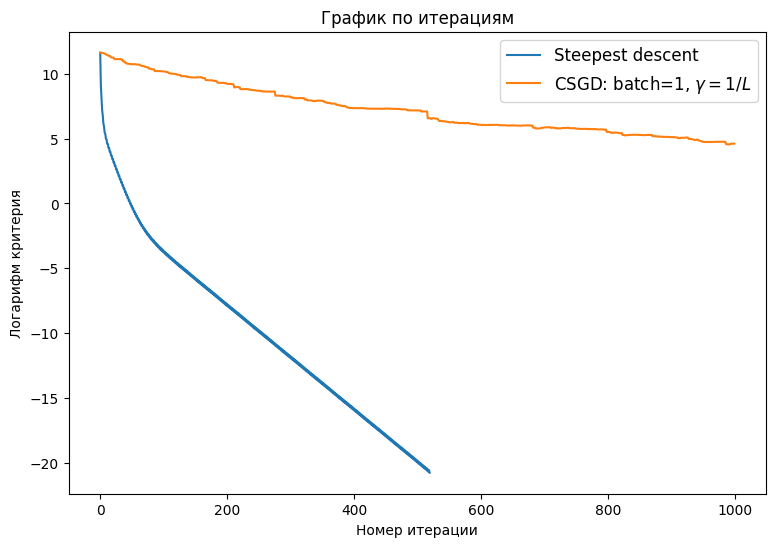

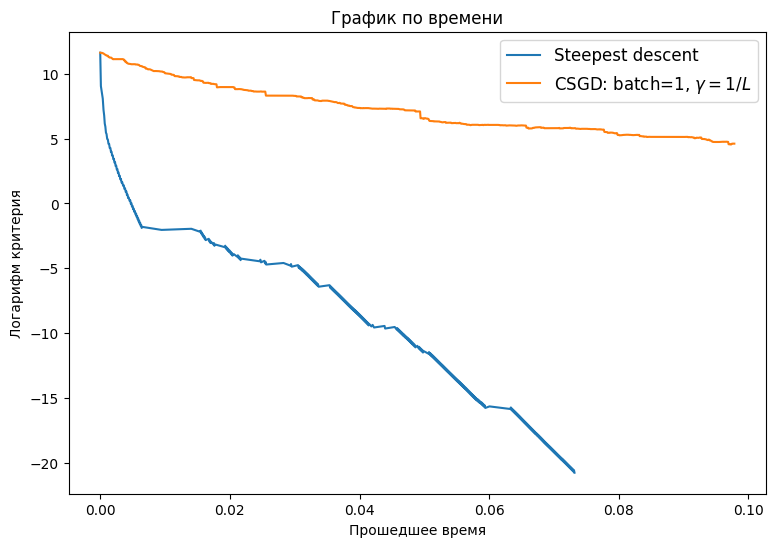

In [135]:
iters = 1000
x_, f_, times_, errs_ = gd_fast(x0=x0, iters=iters)
x1, f1, times1, errs1 = csgd(x0=x0, gamma=2/L, batch=1, batch_type=1, iters=iters)
risovach(times=[times_, times1], errs=[errs_, errs1], labels=[r'Steepest descent', r'CSGD: batch=1, $\gamma = 1/L$'])

Выше был реализован простейший координатный спуск, который на каждой итерации спускается по одной случайной координате. Сходимость имеется, но метод колоссально проигрывает наискорейшему спуску. 

__(б)__ В координатном спуске можно брать несколько координат вместо одной. Модифицируйте координнатный спуск, исходя из этого, пробуя разное число координат $b = 1, 5, 10, 20$, а также разные способы сэмплирования: все координатны независимо или зависимо, чтобы не было повторений в батче. Постройте графики аналогичные пункту (а). Сделайте вывод.

В начале проведем эксперимент с независимым выбором координат. В таком случае могут возникнуть повторы в множестве индексов, и на определенной итерации конкретная компонента градиента может считаться несколько раз.

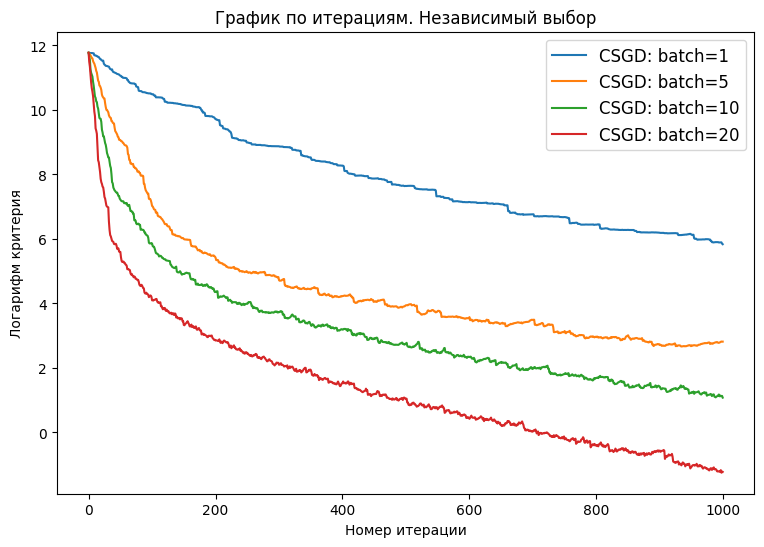

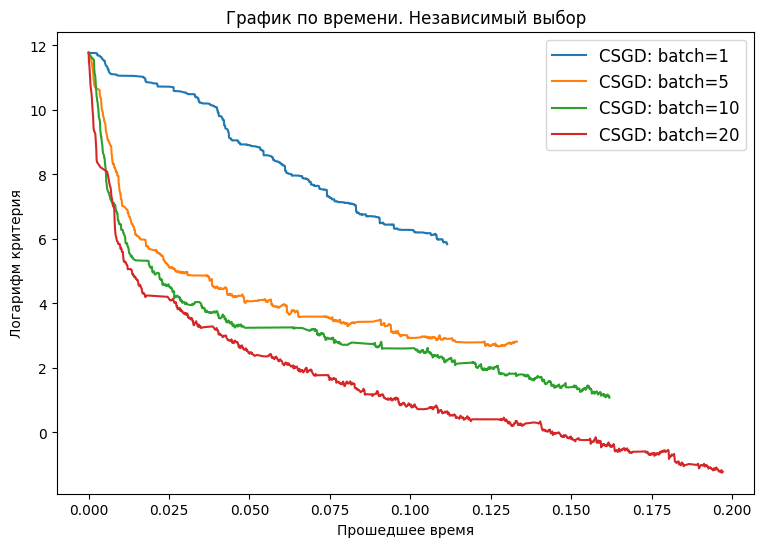

In [46]:
iters = 1000
x1, f1, times1, errs1 = csgd(x0=x0, gamma=1/L, batch=1, batch_type=1, iters=iters)
x5, f5, times5, errs5 = csgd(x0=x0, gamma=1/L, batch=5, batch_type=1, iters=iters)
x10, f10, times10, errs10 = csgd(x0=x0, gamma=1/L, batch=10, batch_type=1, iters=iters)
x20, f20, times20, errs20 = csgd(x0=x0, gamma=1/L, batch=20, batch_type=1, iters=iters)
risovach(times=[times1, times5, times10, times20], errs=[errs1, errs5, errs10, errs20], 
         labels=[r'CSGD: batch=1', r'CSGD: batch=5', r'CSGD: batch=10', r'CSGD: batch=20'],
         title='. Независимый выбор')

Чем больше размер батча, тем лучше сходимость по итерациям. В то же время существенно растет время работы метода. Особенно это заметно при батчах больше 20.

В качестве оптимального возьмем 20.


Эксперимент с зависимым выбором координат. На каждой итерации будет подсчитываться ровно batch различных компонент градиента.

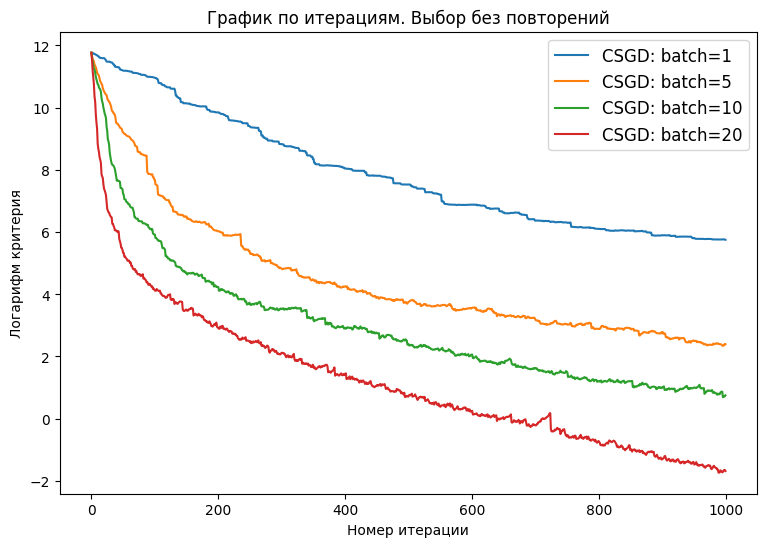

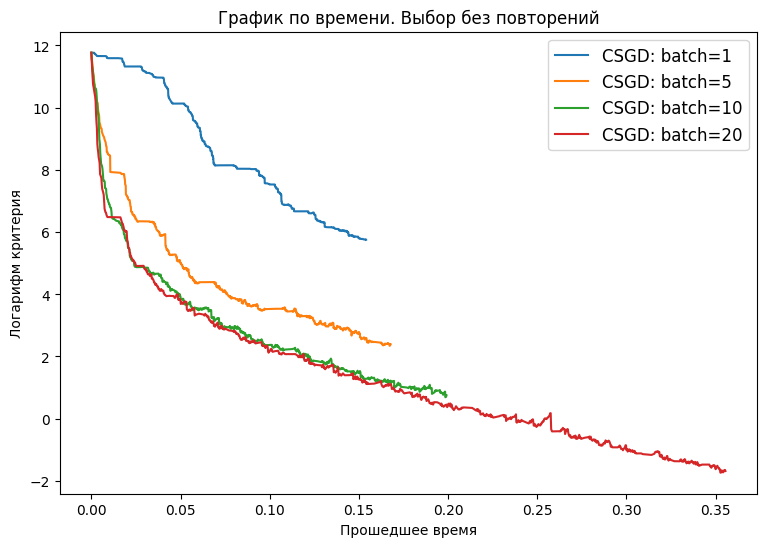

In [47]:
iters = 1000
x1, f1, times1, errs1 = csgd(x0=x0, gamma=1/L, batch=1, batch_type=2, iters=iters)
x5, f5, times5, errs5 = csgd(x0=x0, gamma=1/L, batch=5, batch_type=2, iters=iters)
x10, f10, times10, errs10 = csgd(x0=x0, gamma=1/L, batch=10, batch_type=2, iters=iters)
x20, f20, times20, errs20 = csgd(x0=x0, gamma=1/L, batch=20, batch_type=2, iters=iters)
risovach(times=[times1, times5, times10, times20], errs=[errs1, errs5, errs10, errs20], 
         labels=[r'CSGD: batch=1', r'CSGD: batch=5', r'CSGD: batch=10', r'CSGD: batch=20'],
         title='. Выбор без повторений')

Картина практически не отличается от предыдущей. В качестве оптимального вновь возьмем batch=20. Сравним эти два подхода.

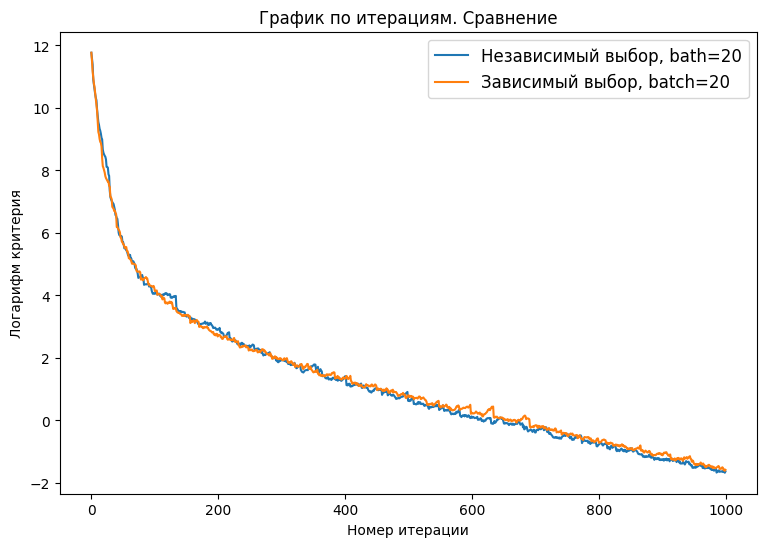

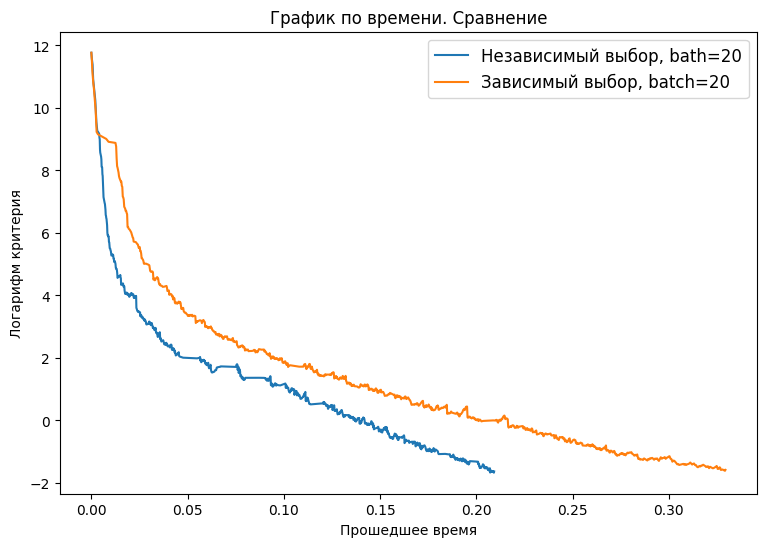

In [52]:
iters = 1000
x10, f10, times10, errs10 = csgd(x0=x0, gamma=1/L, batch=20, batch_type=1, iters=iters)
x20, f20, times20, errs20 = csgd(x0=x0, gamma=1/L, batch=20, batch_type=2, iters=iters)
risovach(times=[times10, times20], errs=[errs10, errs20], 
         labels=[r'Независимый выбор, bath=20', r'Зависимый выбор, batch=20'],
         title='. Сравнение')

Видим, что по итерациям оба подхода работают одинаково. Казалось бы, итерация при независимом выборе более информативна и должна быстрее приближать нас к оптимуму. А нет.

По времени независимый выбор сходится лучше - итерация зависимого выбора более дорогая.

Далее будем пользоваться независимым выбором.

## Задача 2

Рассмотрим задачу линейной регрессии на датасете mushrooms с $\ell_2$-регуляризацией (коэффициент регуляризации равен $\frac{L}{1000}$). 

__(а)__ Оцените $\mu$ и $L$ для данной задачи. 

In [145]:
from sklearn.datasets import load_svmlight_file 
from sklearn.model_selection import train_test_split 

data = load_svmlight_file('mushrooms.txt')  
X, y = data[0].toarray(), data[1]  

n, d = X.shape
y = 2 * y - 3

In [146]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [147]:
num = X_train.shape[0]
L = 0
m = 10

for i in range(num):  
    hessian = np.zeros((d, d)) 
    v = np.reshape(X_train[i], (d, 1))
    hessian += np.dot(v, v.T)
    hessian /= 4

    eig = np.linalg.eigvals(hessian)
    L_i = max(eig)
    m_i = min(eig)
    if (L_i > L): 
        L = L_i
    if (m_i < m):
        m = m_i

print(f'L = {np.real(L)}')
print(f'mu = {np.real(m)}')

L = 5.25
mu = -3.544983541696406e-17


In [148]:
L = 5.25
x0 = np.random.uniform(low=-1, high=1, size=(d,))

__(б)__ Реализуйте координатный SGD, SEGA для задачи линейно регрессии. Каким будете брать $b$? Как будете выбирать шаг и другие параметры методов?

Задача запишется следующим образом:
\begin{equation*}
    f(w) = \dfrac{1}{n} \left( \| Xw - y \|^2 + \dfrac{L}{1000} \|w\|^2 \right) = \dfrac{2}{n} \left(\frac{1}{2} w^TX^TXw - y^TXw + \dfrac{1}{2} y^Ty + \dfrac{L}{2000} \|w\|^2\right)
\end{equation*}

\begin{equation*}
    A = \dfrac{2}{n} X^TX, \; b = \dfrac{2}{n} y^TX, \; c = \dfrac{1}{n} y^Ty \Rightarrow 
\end{equation*}

\begin{equation*}
    \Rightarrow  f(\omega) = \dfrac{1}{2} w^TAw - b^Tw + c + \dfrac{L}{1000 \cdot n} \|w\|^2
\end{equation*}

\begin{equation*}
    \nabla f(\omega) = Aw - b^T + \dfrac{2L}{1000 \cdot n} w
\end{equation*}

In [149]:
n_train = X_train.shape[0]
A = 2 / n_train * X_train.T @ X_train
b = 2 / n_train * y_train.T @ X_train
c = 1 / n_train * y_train.T @ y_train

from numba import jit

def f(w):
    return 0.5 * w.T @ A @ w - b.T @ w + c + L/(1000 * n_train) * np.linalg.norm(w)**2

def grad(w):
    return A @ w - b.T + 2 * L/(1000 * n_train) * w

def grad_i(w, i):
    return A[i] @ w - b[i] + 2 * L / (1000 * n_train) * w[i]

In [208]:
def sega(x0, gamma=1/L, batch=10,error=err_gradnorm, iters=2000, eps=1e-9):
    
    x = x0
    x_vals = [x]
    f_vals = [f(x)]
    times = [0.]
    errs = [error(x)]

    start = time.time()
    g = grad(x)

    for i in range(1, iters):

        a = random.sample(range(d), batch)
        for j in a:
            g[j] = grad_i(x, j)
        x = x - gamma * g

        x_vals.append(x)
        f_vals.append(f(x))
        times.append(time.time() - start)
        err = error(x)
        errs.append(err)

        if err < eps:
            break

    return x_vals, f_vals, times, errs

def csgd(x0, gamma, batch=1, error=err_gradnorm, iters=2000, eps=1e-9):
    x = x0
    x_vals = [x]
    f_vals = [f(x)]
    times = [0.]
    errs = [error(x)]

    start = time.time()

    for i in range(1, iters):

        g = np.zeros((d,))
        a = random.sample(range(d), batch)
        for j in a:
            g[j] = grad_i(x, j)

        x = x - gamma * g

        x_vals.append(x)
        f_vals.append(f(x))
        times.append(time.time() - start)
        errs.append(error(x))

        if error(x) < eps:
            break

    return x_vals, f_vals, times, errs

Подберем теперь оптимальный размер батча для SEGA и CSGD. Начнем с CSGD.

In [226]:
x_csgd_5, _, times_csgd_5, errs_csgd_5 = csgd(x0=x0, gamma=1/L, batch=5)
x_csgd_10, _, times_csgd_10, errs_csgd_10 = csgd(x0=x0, gamma=1/L, batch=10)
x_csgd_30, _, times_csgd_30, errs_csgd_30 = csgd(x0=x0, gamma=1/L, batch=30)
x_csgd_50, _, times_csgd_50, errs_csgd_50 = csgd(x0=x0, gamma=1/L, batch=50)

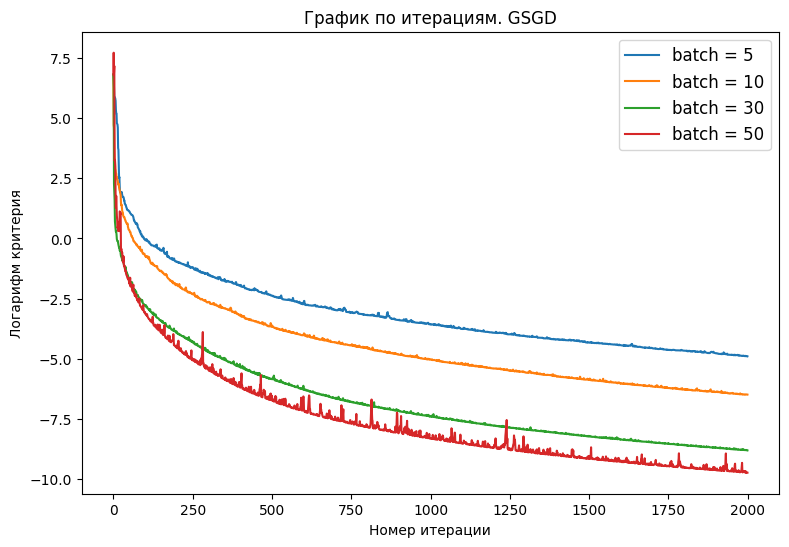

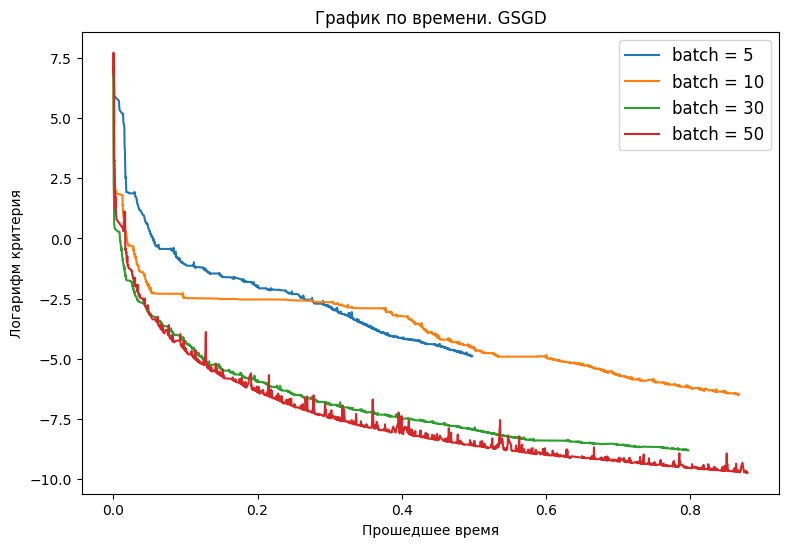

In [227]:
risovach(times=[times_csgd_5, times_csgd_10, times_csgd_30, times_csgd_50], 
         errs=[errs_csgd_5, errs_csgd_10, errs_csgd_30, errs_csgd_50], 
         labels=['batch = 5', 'batch = 10', 'batch = 30', 'batch = 50'],
         title='. GSGD')

In [224]:
x_sega_10, _, times_sega_10, errs_sega_10 = sega(x0=x0, gamma=1/(4*L), batch=10)
x_sega_20, _, times_sega_20, errs_sega_20 = sega(x0=x0, gamma=1/(2*L), batch=20)
x_sega_40, _, times_sega_40, errs_sega_40 = sega(x0=x0, gamma=1/L, batch=40)
x_sega_60, _, times_sega_60, errs_sega_60 = sega(x0=x0, gamma=1/L, batch=60)

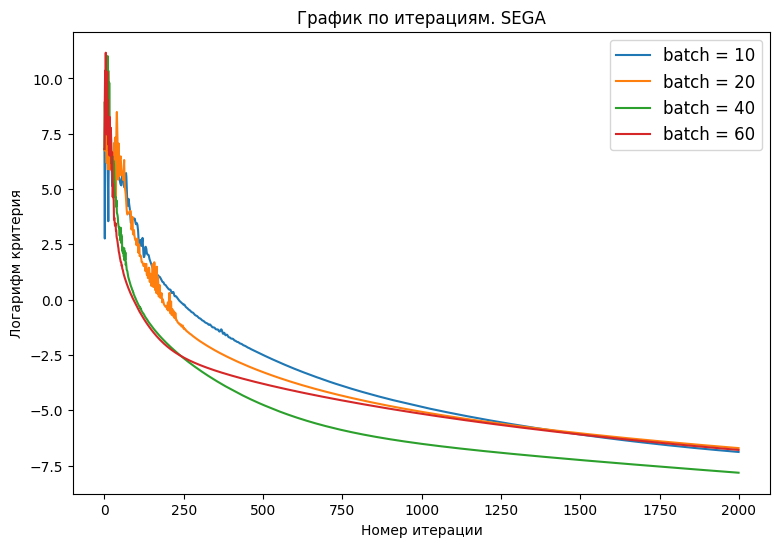

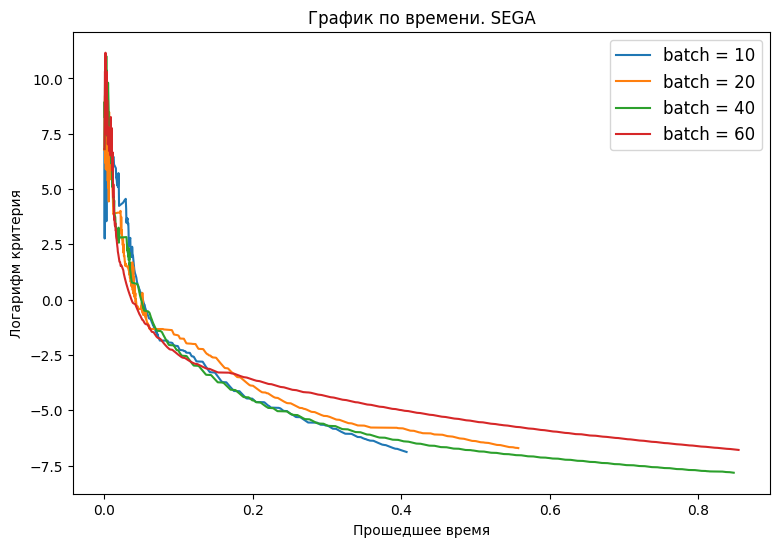

In [225]:
risovach(times=[times_sega_10, times_sega_20, times_sega_40, times_sega_60], 
         errs=[errs_sega_10, errs_sega_20, errs_sega_40, errs_sega_60], 
         labels=['batch = 10', 'batch = 20', 'batch = 40', 'batch = 60'],
         title='. SEGA')

Для CSGD в качестве оптимального батча возьмем 50: при нем наблюдается лучшая сходимость и итерациям, и по времени. 

С SEGA дела обстоят интереснее: большой батч дает хорошую сходимость по итерациям, но с этим и увеличивается время работы. При этом в слишком жирном батче смысла тоже нет - часто выходит так, что меньший батч отрабатывает лучше даже по итерациям (как и произошло в последнем запуске, результаты которого выше). Также экспериментально замечено, что при небольшом размере батча для сходимости метода нужен маленький шаг, при большом шаг можно делать больше. Наблюдается некоторый паритет между размером шага и батча. 

С точки зрения эффективности метода по времени, оптимальным будет и не большой, и не малый размер батча. Опыт показывает, что лучшие результаты показывает 40.

__(в)__ Постройте графики сравнения всех методов: по оси $x$ используйте время или количество арифметических операций, по оси $y$ - $\|\nabla f(x^k)\|$ или точность на тесте. Таким образом, всего 4 графика. Сделайте сравнение и вывод.

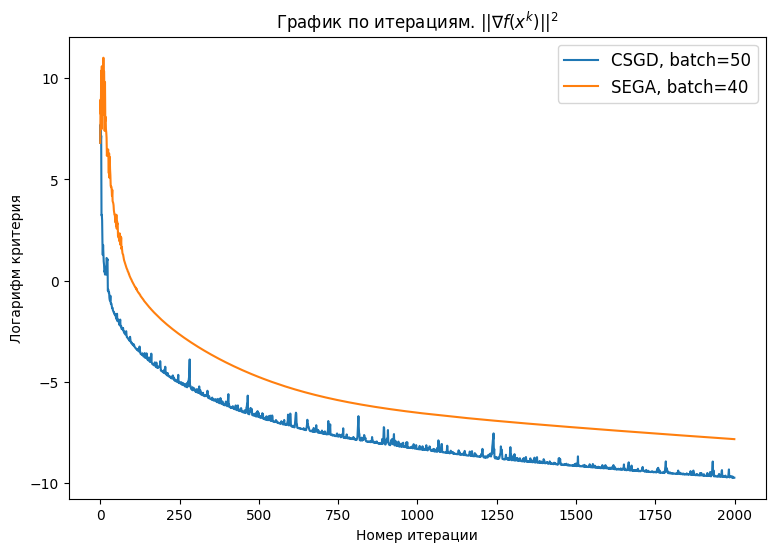

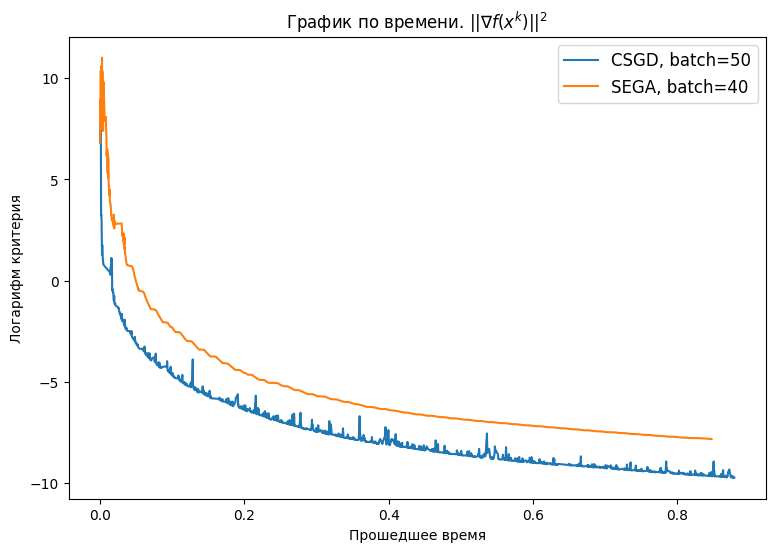

In [244]:
risovach(times=[times_csgd_50, times_sega_40], 
         errs=[errs_csgd_50, errs_sega_40],
         labels=['CSGD, batch=50', 'SEGA, batch=40'],
         title=r'. $||\nabla f(x^k)||^2$')

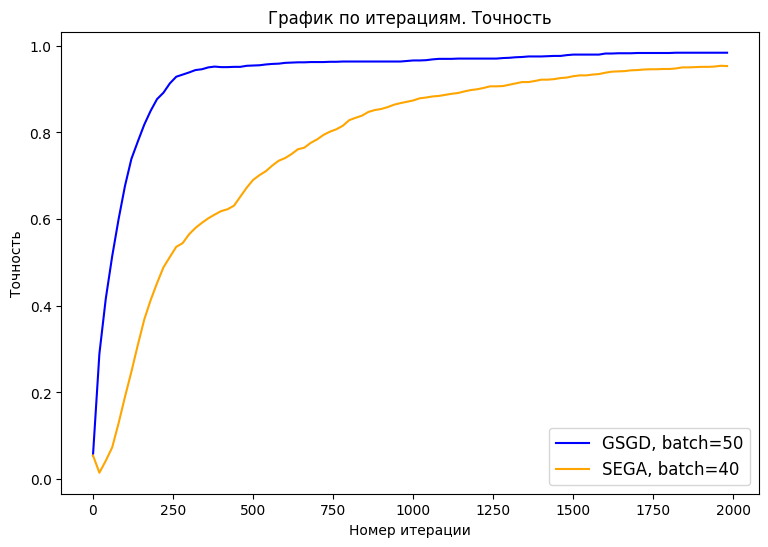

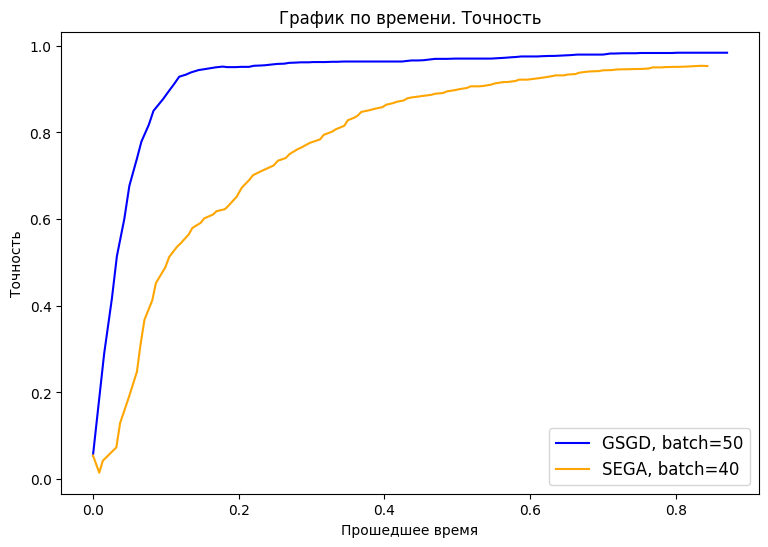

In [243]:
from sklearn.metrics import accuracy_score

n1, acc1 = [], []
for i in range(0, 2000, 20):
    w = x_csgd_50[i]
    n1.append(i)
    acc1.append(accuracy_score([round(x) for x in (X_test @ w)], y_test))

n2, acc2 = [], []
for i in range(0, 2000, 20):
    w = x_sega_40[i]
    n2.append(i)
    acc2.append(accuracy_score([round(x) for x in (X_test @ w)], y_test))

plt.figure(figsize = (9, 6))
plt.plot(n1, acc1, color = 'blue', label = "GSGD, batch=50")
plt.plot(n2, acc2, color = 'orange', label = "SEGA, batch=40")
plt.xlabel("Номер итерации")
plt.ylabel("Точность")
plt.legend(fontsize = 12)
plt.title('График по итерациям. Точность')
plt.show()

plt.figure(figsize = (9, 6))
plt.plot(times_csgd_50[::20], acc1, color = 'blue', label = "GSGD, batch=50")
plt.plot(times_sega_40[::20], acc2, color = 'orange', label = "SEGA, batch=40")
plt.xlabel("Прошедшее время")
plt.ylabel("Точность")
plt.legend(fontsize = 12)
plt.title('График по времени. Точность')
plt.show()

В моем эксперименте координатный спуск обошел SEGA и по итерациям, и по точности на тесте. Время работы обоих методов практически совпало.

__Бонусные пункты__

__(г)__ Попробуйте объеденить подходы SAGA/SVRG/L-SVRG и координатный SGD/SEGA (т.е. могут получиться пары SAGA + координатный, SVRG + SEGA и еще четыре других). Вам достаточно выбрать одну пару. Как при этом будет выглядеть итерация метода (запишите в явном виде)? Докажите сходимость данного подхода для $\mu$-сильно выпуклой $f$ и $L$-гладкой $f_i$.

In [195]:
#ответ

__(д)__ Реализуйте новый метод. Сравните его с двумя методами, которые были взяты за базу, на задаче линейной регресии. Способы сравнения методов придумайте самостоятельно. Сделайте вывод.

In [196]:
#ответ